<a href="https://colab.research.google.com/github/darkxaze/Machinelearnning-courseworkprojects/blob/main/BloodMNISTmynetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Medical Image Analysis 
A simple convolutional neural network model trained using a simple pathology image dataset.The dataset used is <bold>BloodMNIST

To use GPU acceleration make sure to change your runtime type in Google Colab to GPU.

## Python Imports
This section will load the necessary python packages to the instance.

In [1]:
# Built-in Imports
import random

In [2]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance. 

To change the dataset that will download just change the variable DATA_NAME to desired dataset name.

All storage on a Google Colab instance is deleted when the instance ends so the dataset will need to be redownloaded each time an instance is created (Don't worry this usually takes about 20 seconds).

The dataset used in the current model is called Bloodmnist. All images are RGB and have 3 channel. The images are standaized and are 28x28 in size.

In [4]:
DATA_NAME = "BloodMNIST"

In [5]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2022-04-08 15:47:52--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22843 (22K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  22.31K  --.-KB/s    in 0.001s  

2022-04-08 15:47:52 (21.9 MB/s) - ‘info.py’ saved [22843/22843]



In [6]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz", 
                     origin=data["url"], 
                     md5_hash=data["MD5"])

35471360/35461855 [==============================] - 3s 0us/step


In [7]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object and normalize it.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]
train_x = train_x.astype('float32') / 255

# Gets the validation images and labels from the NumPy object and normalize it.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]
val_x = val_x.astype('float32') / 255

# Gets the testing images and labels from the NumPy object and normalize it.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]
test_x = test_x.astype('float32') / 255

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [8]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]
targetnames=list(data["label"].values())

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]), 
                            np.append(val_counts, [sum(val_counts)]), 
                            np.append(test_counts, [sum(test_counts)]))), 
                   index=labels, columns=["Train", "Val", "Test"]))

                                                    Train   Val  Test
basophil                                              852   122   244
eosinophil                                           2181   312   624
erythroblast                                         1085   155   311
immature granulocytes(myelocytes, metamyelocyte...   2026   290   579
lymphocyte                                            849   122   243
monocyte                                              993   143   284
neutrophil                                           2330   333   666
platelet                                             1643   235   470
total                                               11959  1712  3421


5737: immature granulocytes(myelocytes, metamyelocytes and promyelocytes)


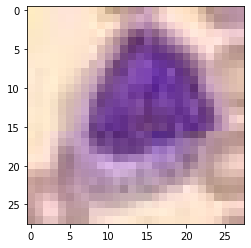

In [9]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[index])

## Data Processing
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

Data processing is applied to the dataset to auguement data when the size of the data set is small. The advantages of data augmentation are as follows:

  

*   It reduces the cost of collection of data.
*   It reduces data overfitting.
*   It creates variability and flexibility in data models.



In the model applied we implement horizontal flipping,vertical flipping, 
featurewise Pixel Normalization: scale pixel values to the range 0-1.
featurewise Pixel Centering: scale pixel values to have a zero mean.

featurewise here means per dataset

The fit function is then invoked to calculate the image statistics in the data generator function and store the value in memory
    


In [10]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True, 
                                    vertical_flip=True)

In [11]:
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition
In this section we will define the neural network arcitecture.

The chosen model here consists of an input layer which takes in the shape of the data set (28x28x3). Followed by a convolution layer. A convolution layer transforms the input image in order to extract features from it. The layer was invoked from keras with with the following arguments



*   Filters : determinesthe number of output filters in the convolution 

*   Kernel size : A tuple/list specifying the height and width of the 2D convolution window
*   Activation : Specifies the activation function of the convolution layer

Since we havent defined the model as sequential we specify how this model is connected at the end of the initiation.

After convolution layer we have the pooling layer. Pooling layers provide an approach to down sampling feature maps by summarizing the presence of features in patches of the feature map. the pooling layer has  a pool size of 2,2 over which the max value is considered. we have two blocks of conv layer followed vy maxpool layer. 

Then we flatten the dataset. Flattening is used to convert all the resultant 2-Dimensional arrays from pooled feature maps into a single long continuous linear vector. The flattened matrix is fed as input to the fully connected layer to classify the image. This is followed by a dropout layer. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

we also have densely connected layers with L2 regularization applied with a lambda of 0.01. It adds an L2 penalty which is equal to the square of the magnitude of coefficients and purpose of L2 regularization is to reduce the chance of model overfitting

The final layer applies a softmax activation to classify the data and has 8 output nodes.



In [12]:
# Define the input layer of the model with the size of an image.
from keras import regularizers
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
conv_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(conv_1)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Defines the second convolutional layer with max pooling.
conv_3 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(pool_1)
conv_4 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(conv_3)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_4)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_2)

# create densely connected layers with dropputs and L2 regularization 
dense1 = layers.Dense(units=200, activation="relu")(flatten)
dropout1 = layers.Dropout(0.7)(dense1)
dense2 = layers.Dense(units=200, activation="relu",kernel_regularizer=regularizers.l2(0.01))(dropout1)
dropout2 = layers.Dropout(0.7)(dense2)
dense3 = layers.Dense(units=200, activation="relu",kernel_regularizer=regularizers.l2(0.01))(dropout2)
# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(dense3)

# Initilises the defined model and prints summary of the model.
model = Model(inputs=input, outputs=output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                             

## Model Training
This is where we define the training options and then train the model.



*   The batch size is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
*   The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.

*   learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated.


*   Loss functions measure how far an estimated value is from its true value
*   Metrics are used to evaluate the model. Accuracy Calculates how often predictions equal labels. 

*   Shuffle is set to false so that no shuffling of data takes places when augumenting data to preserve index

* Adam optimizer is used because they are better than every other optimization algorithms, have faster computation time, and require fewer parameters for tuning.










In [13]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

In [24]:
# Defines the optimiser used to adjust the model weights and compiles the model.
from tensorflow import keras
#optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])

In [15]:
# We use the data generator to pass the training and validation data to the model to train it.
history = model.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE), shuffle=False, 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE,shuffle=False),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/20
186/186 [==============================] - 14s 17ms/step - loss: 2.8055 - accuracy: 0.4050 - val_loss: 1.4410 - val_accuracy: 0.6086
Epoch 2/20
186/186 [==============================] - 3s 14ms/step - loss: 1.1556 - accuracy: 0.6805 - val_loss: 0.8206 - val_accuracy: 0.7564
Epoch 3/20
186/186 [==============================] - 3s 15ms/step - loss: 0.8568 - accuracy: 0.7486 - val_loss: 0.7113 - val_accuracy: 0.7681
Epoch 4/20
186/186 [==============================] - 3s 15ms/step - loss: 0.7596 - accuracy: 0.7656 - val_loss: 0.6796 - val_accuracy: 0.7804
Epoch 5/20
186/186 [==============================] - 3s 15ms/step - loss: 0.6810 - accuracy: 0.7908 - val_loss: 0.6012 - val_accuracy: 0.8037
Epoch 6/20
186/186 [==============================] - 3s 15ms/step - loss: 0.6381 - accuracy: 0.8044 - val_loss: 0.6185 - val_accuracy: 0.8008
Epoch 7/20
186/186 [==============================] - 3s 15ms/step - loss: 0.6114 - accuracy: 0.8099 - val_loss: 0.5020 - val_accuracy: 0.825

## Plot Learning Curves
This is where we visualise the training of the model.

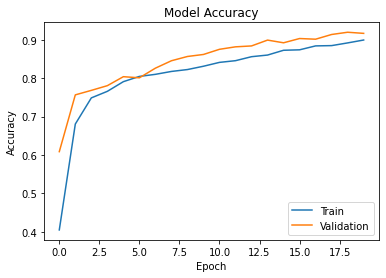

In [16]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

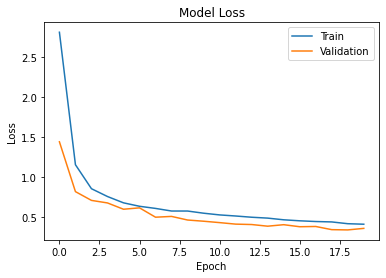

In [17]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

From the above graphs we can determine 10 epochs is enough to get a good prediction and prevent overfitting. therefore redifining new model for 10 epochs which will be used to predict values and evaluate the model.

In [33]:
# Define the input layer of the model with the size of an image.
from keras import regularizers
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
conv_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(conv_1)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Defines the second convolutional layer with max pooling.
conv_3 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(pool_1)
conv_4 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(conv_3)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_4)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_2)

# create densely connected layers with dropputs and L2 regularization 
dense1 = layers.Dense(units=200, activation="relu")(flatten)
dropout1 = layers.Dropout(0.7)(dense1)
dense2 = layers.Dense(units=200, activation="relu",kernel_regularizer=regularizers.l2(0.01))(dropout1)
dropout2 = layers.Dropout(0.7)(dense2)
dense3 = layers.Dense(units=200, activation="relu",kernel_regularizer=regularizers.l2(0.01))(dropout2)
# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(dense3)

# Initilises the defined model and prints summary of the model.
model1 = Model(inputs=input, outputs=output, name="Model")
model1.summary()
NUM_EPOCHS = 10
# adam optimizer is used instead of SGD
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
history = model1.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE), shuffle=False, 
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE,shuffle=False),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)


Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 26, 26, 32)        896       
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 10, 10, 32)        9248      
                                                                 
 conv2d_19 (Conv2D)          (None, 8, 8, 32)          9248      
                                                             

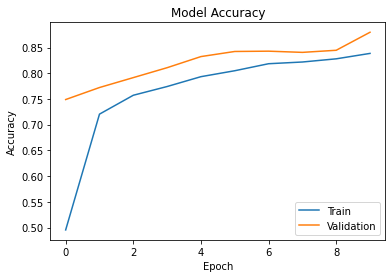

In [34]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

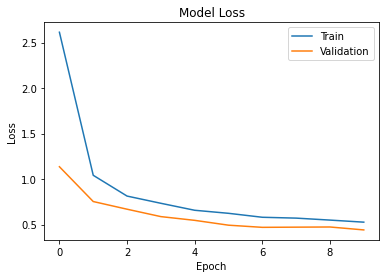

In [35]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluate Data
We evaulate data using the model.evaluate function and passing the test data and the corresponding test labels. we use the model train to predict values based on test data and compare it to test lables to predict accuracy.

In [37]:
model1.evaluate(data_generator.flow(test_x, to_categorical(test_y)))

107/107 [==============================] - 1s 8ms/step - loss: 0.4719 - accuracy: 0.8667


[0.47188037633895874, 0.8667056560516357]

In [38]:
# predict values using the augumented test data set
ypred=model1.predict(data_generator.flow(test_x,batch_size=BATCH_SIZE,shuffle=False))
# convert probability distribution to index of the class
ypred1 = np.argmax(ypred, 1)
# convert to categorical
testy1=to_categorical(test_y,num_classes=8)
# identify the index of the class
testy2= np.argmax(testy1, 1)
print(classification_report(testy2, ypred1,target_names=targetnames))

                                                                     precision    recall  f1-score   support

                                                           basophil       0.75      0.86      0.81       244
                                                         eosinophil       0.99      0.99      0.99       624
                                                       erythroblast       1.00      0.83      0.90       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.70      0.57      0.63       579
                                                         lymphocyte       0.83      0.91      0.87       243
                                                           monocyte       0.56      0.67      0.61       284
                                                         neutrophil       0.93      0.99      0.96       666
                                                           platelet       1.00      1.00      1.00       470

                 

##Inference
In this exercise we classify an Multi-class(8) dataset with a Convolution neural network. our model consist of an input layer which takes 28x28x3 as input , 2 blocks each containing 2 convolution layers, 1 maxpool layers. This is followed by  a series of densely connected neural network that are regularized by both L2 and dropout method, and finaly an output layer with 8 neurons. The total number of trainable parameters is 213248. The proposed model has an accuracy of 86%  with the augumented test dataset. This in line with the predicted values in the classification report. The testdataset is augumented because we need the test set to be similar to the training set due to image processing like standardization,centering,cropping etc. The main advantage of CNN compared to its predecessors is that it automatically detects the important features without any human supervision.

Some key points learnt in this exercises are :


*   Data augumentation is essential when the size of the dataset is small. it reduces over fitting.
*   L2 and Dropout regularization are some of the methods used with dropout being more popular in CNN networks.

*   Softmax and categorical cross entropy are used since we are performing a multi-class classification.
*   steps to try out in the future to improve accuracy to the max are by trying different activation functions, learningrate, kernel size, filter size  and increasing the width of the network.
*   Transfer learning can be applied with resnet,VGG-19 etc as base models to achieve higher efficiency and reduce computational cost.

F1 score is a combined metric defined as product of precision*recall over the sum of precision and recall. Precision is defined as true positive over sum of true positive and false positive, Recall is definied as the true positive over sum of true positive and false negative. Precision can be seen as a measure of quality, and recall as a measure of quantity. Higher precision means that an algorithm returns more relevant results than irrelevant ones, and high recall means that an algorithm returns most of the relevant results. Our ideal value is getting a 1 on F1 score meaning 1 on both precision as well as recall.
From the classification report we can see that platelets has a score of 1.00 compared 0.98 for simple CNN and 0.96 for DNN, meaning its being classified correctly and repeatedly.basophil for instance has a F1 score of 0.81 for our model compared to 0.01 for DNN and 0.25 for CNN. this example shows how much more accurate our model is at classification compared to simple models. more complex models with more parameters will further increase the accuracy but will asldo increase computational cost. we have to strive for a balance between them. 

So In conclusion MyModel(0.86)>CNN(0.65)>DNN(0.49) in classifying the given BloodMNIST dataset based on accuracy.



